In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def numpy_metrics(y_pred, y_true, n_classes=11, void_labels=[11]):
    """
    Similar to theano_metrics to metrics but instead y_pred and y_true are now numpy arrays
    from: https://github.com/SimJeg/FC-DenseNet/blob/master/metrics.py
    void label is 11 by default
    """

    # Put y_pred and y_true under the same shape
    y_pred = np.argmax(y_pred, axis=1)

    # We use not_void in case the prediction falls in the void class of the groundtruth
    not_void = ~np.any([y_true == label for label in void_labels], axis=0)

    I = np.zeros(n_classes)
    U = np.zeros(n_classes)

    for i in range(n_classes):
        y_true_i = y_true == i
        y_pred_i = y_pred == i

        I[i] = np.sum(y_true_i & y_pred_i)
        U[i] = np.sum((y_true_i | y_pred_i) & not_void)

    accuracy = np.sum(I) / np.sum(not_void)
    return I, U, accuracy

In [3]:
def eval_uncertaintry_metrics(y_pred, y_true, uncertainty_map, patch_size=7, acc_threshold=0.5, cert_threshold=0.4):
    #TODO verify y_pred, y_true size and representation
    # Assume y_pred (batch_size, num_classes, h, w) where h = w = 224
    # y_true (batch_size, h, w)

    batch_size, num_classes, w, h = y_pred.shape

    # Put y_pred and y_true under the same shape
    y_pred = np.argmax(y_pred, axis=1)
    
    acc_flag = y_pred == y_true
    acc_grid = acc_flag.reshape(batch_size, w//patch_size, patch_size, h//patch_size, patch_size)
    acc_grid = np.swapaxes(acc_grid, 2, 3).reshape(batch_size, -1, patch_size, patch_size)
    _, num_patch, _, _ = acc_grid.shape
    acc_rate = np.sum(np.sum(acc_grid, axis=3), axis=2)/(patch_size * patch_size) # (batch_size, w//patch_size * h//patch_size)

    cert_grid = uncertainty_map.reshape(batch_size, w//patch_size, patch_size, h//patch_size, patch_size)
    cert_grid = np.swapaxes(cert_grid, 2, 3).reshape(batch_size, -1, patch_size, patch_size)
    cert_rate = cert_grid.mean(axis=(2,3)) # (batch_size, w//patch_size * h//patch_size)

    acc = acc_rate > acc_threshold
    cert = cert_rate < cert_threshold
    
    ac = np.logical_and(acc, cert)
    au = np.logical_and(acc, np.logical_not(cert))
    ic = np.logical_and(np.logical_not(acc), cert)
    iu = np.logical_and(np.logical_not(acc), np.logical_not(cert))
    
    n_ac = np.sum(ac, axis=1)
    n_au = np.sum(au, axis=1)
    n_ic = np.sum(ic, axis=1)
    n_iu = np.sum(iu, axis=1)

    p_a_c = n_ac/(n_ac + n_ic) # p(accurate|certain)
    p_u_i = n_iu/(n_ic + n_iu) # p(uncertain|inaccurate)
    pa_v_pu = (n_ac + n_iu)/num_patch # Patch Accuracy vs Patch Uncertainty
    
    ac = ac.reshape(batch_size, w//patch_size, h//patch_size)
    au = au.reshape(batch_size, w//patch_size, h//patch_size)
    ic = ic.reshape(batch_size, w//patch_size, h//patch_size)
    iu = iu.reshape(batch_size, w//patch_size, h//patch_size)
    
    print(p_a_c.mean(), p_u_i.mean(), pa_v_pu.mean())
    return p_a_c, p_u_i, pa_v_pu, ac, au, ic, iu

In [4]:
def softmax(x, axis=1):
    return np.exp(x) / np.sum(np.exp(x),axis=axis, keepdims=True)

In [5]:
def ece(outputs, labels, name="", bins=np.arange(0.1, 1.05, 0.05), print_name=False, background_label = 11):

    if outputs is None:
        ece = None
    else:
        confidences = np.max(outputs, 1)
        predictions = np.argmax(outputs,1)
        bin_lowers = bins[:-1]
        bin_uppers = bins[1:]
        
        accuracies = predictions == labels 

        #ece = Variable(torch.zeros(1)).type_as(confidences)
        ece = 0.0
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = (confidences > bin_lower) * (confidences < bin_upper)
            prop_in_bin = in_bin.mean()
            if prop_in_bin > 0:
                accuracy_in_bin = accuracies[in_bin].mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += np.abs(avg_confidence_in_bin-accuracy_in_bin) * prop_in_bin
    if print_name:
        print(name, end=": ")
    if ece is not None:
        print("%.3f"%ece)
    else:
        print("-")
    return ece



In [6]:
def compute_mIOU_acc(loc, output_probs = True, background_class = 11):
    npz_arr = np.load(loc)
    
    if output_probs:
        pred_probs = npz_arr['predictions']
    else:
        pred_probs = softmax(npz_arr['preds'],1)
    targets = npz_arr['targets']
    
    I, U, acc = numpy_metrics(pred_probs, targets)
    mIOU = np.mean(I / U)
    
    filtered_targets = targets.reshape(-1)
    background_labels = filtered_targets == background_class
    filtered_targets = filtered_targets[~background_labels]
    
    filtered_pred_probs = pred_probs.reshape(-1, pred_probs.shape[1])
    print(filtered_pred_probs.shape, filtered_pred_probs.sum(1).mean())
    filtered_pred_probs = filtered_pred_probs[~background_labels, :]
    
    ece_val = ece(filtered_pred_probs, filtered_targets, print_name=False)
    print(acc, mIOU, ece_val, loc)
    return acc, mIOU, ece_val

In [7]:
import os

In [23]:
dir_to_result = '../../results'
for f in os.listdir(dir_to_result):
    if f[-3:] == 'npz':
        try:
            compute_mIOU_acc(os.path.join(dir_to_result, f))
        except KeyError:
            print(os.path.join(dir_to_result, f))
            continue

(40262400, 11) 1.0000000016474337
0.086
0.8496942987989597 0.5536408041007554 0.086423484649988 ../../results/dropout6.npz
../../results/inputs.npz
(40262400, 11) 0.9999987
0.090
0.9099381577791605 0.6283172410429111 0.09042508274686888 ../../results/ensemble.npz
(40262400, 11) 0.25930288
0.039
0.9012711763834294 0.612040623853118 0.03924290032709632 ../../results/sgd6.npz
(40262400, 11) 0.48673734
0.037
0.9042034564048979 0.6253182325877055 0.0373772587524619 ../../results/swa5.npz
(40262400, 11) 1.0000000122375827
0.092
0.904760288723239 0.6265125311594943 0.09238364787416499 ../../results/swag_cov5.npz
(40262400, 11) 1.0000000143747965
0.093
0.9004973447543877 0.6174847548062444 0.09308999104848473 ../../results/swag_diag2.npz
(40262400, 11) 1.0000000132701454
0.091
0.9107598986823452 0.6394103315447679 0.09122935654335379 ../../results/multiswag_cov.npz


In [8]:
dir_to_result = '../../results'
inputs = np.load(os.path.join(dir_to_result, 'inputs.npz'))['inputs']

Patch size 6

In [22]:
for f in os.listdir(dir_to_result):
    if f[-3:] == 'npz':
        try:
            print(f)
            npz_arr = np.load(os.path.join(dir_to_result, f))
            
            targets = npz_arr['targets']
            pred = npz_arr['predictions']
            pred_uncertainty = npz_arr['predictive_entropy']
            mut_uncertainty = npz_arr['mutual_information']
            
#             p_a_c, p_u_i, pa_v_pu, ac, au, ic, iu = \
            eval_uncertaintry_metrics(pred, targets, pred_uncertainty, patch_size=6, cert_threshold=pred_uncertainty.mean())
            
            
        except KeyError:
            print('output file not correctly formatted')
            print(os.path.join(dir_to_result, f))
            continue

dropout6.npz
0.947075398779665 0.8481554832462865 0.7182188841201718
inputs.npz
output file not correctly formatted
../../results/inputs.npz
ensemble.npz
0.9647633664858241 0.8152312131800264 0.777925608011445
sgd6.npz
output file not correctly formatted
../../results/sgd6.npz
swa5.npz
output file not correctly formatted
../../results/swa5.npz
swag_cov5.npz
0.9617818862074895 0.8016610651827636 0.7800241416309014
swag_diag2.npz
0.9586136528812584 0.7913964702527173 0.7839851573676682
multiswag_cov.npz
0.9679518746077506 0.8306625865570391 0.7711310801144492


Patch size 4

In [45]:
for f in os.listdir(dir_to_result):
    if f[-3:] == 'npz':
        try:
            print(f)
            npz_arr = np.load(os.path.join(dir_to_result, f))
            
            targets = npz_arr['targets']
            pred = npz_arr['predictions']
            pred_uncertainty = npz_arr['predictive_entropy']
            mut_uncertainty = npz_arr['mutual_information']
            
#             p_a_c, p_u_i, pa_v_pu, ac, au, ic, iu = \
            eval_uncertaintry_metrics(pred, targets, pred_uncertainty, patch_size=4, cert_threshold=pred_uncertainty.mean())
            
            
        except KeyError:
            print('output file not correctly formatted')
            print(os.path.join(dir_to_result, f))
            continue


dropout6.npz
0.9442766047130567 0.8446984047840931 0.7233170402161818
inputs.npz
output file not correctly formatted
../../results/inputs.npz
ensemble.npz
0.9623225957350021 0.8083692507537 0.7920648545541248
sgd6.npz
output file not correctly formatted
../../results/sgd6.npz
swa5.npz
output file not correctly formatted
../../results/swa5.npz
swag_cov5.npz
0.9592562464842943 0.7945087497002657 0.7956266889206804
swag_diag2.npz
0.9556102424885901 0.7810638532148598 0.7996530758226037
multiswag_cov.npz
0.9658218197983852 0.8245798305710352 0.7849809251311397


In [24]:
np.arange(0,1,0.2)

array([0. , 0.2, 0.4, 0.6, 0.8])

In [26]:
res_dict = {}
for f in os.listdir(dir_to_result):
    if f[-3:] == 'npz':
        try:
            print(f)
            npz_arr = np.load(os.path.join(dir_to_result, f))
            
            targets = npz_arr['targets']
            pred = npz_arr['predictions']
            pred_uncertainty = npz_arr['predictive_entropy']
            mut_uncertainty = npz_arr['mutual_information']
            
            cert_res = np.zeros((3, len(np.arange(0,1,0.2))))
            for i, cert_t in enumerate(np.arange(0,1,0.2)):
                p_a_c, p_u_i, pa_v_pu, ac, au, ic, iu = \
                eval_uncertaintry_metrics(pred, targets, pred_uncertainty, patch_size=6, cert_threshold=cert_t)
                cert_res[:, i] = p_a_c.mean(), p_u_i.mean(), pa_v_pu.mean()
                
            acc_res = np.zeros((3, len(np.arange(0,1,0.2))))
            for i, acc_t in enumerate(np.arange(0,1,0.2)):
                p_a_c, p_u_i, pa_v_pu, ac, au, ic, iu = \
                eval_uncertaintry_metrics(pred, targets, pred_uncertainty, patch_size=6, \
                                          acc_threshold = acc_t, cert_threshold=pred_uncertainty.mean())
                acc_res[:, i] = p_a_c.mean(), p_u_i.mean(), pa_v_pu.mean()
                
            res_dict[f] = {'cert': cert_res, 'acc': acc_res}
            
            
        except KeyError:
            print('output file not correctly formatted')
            print(os.path.join(dir_to_result, f))
            continue

dropout6.npz


<ipython-input-3-a7f4d9113c37>:34: RuntimeWarning: invalid value encountered in true_divide
  p_a_c = n_ac/(n_ac + n_ic) # p(accurate|certain)


nan 1.0 0.17378934191702433
0.9738695529473269 0.9494903119359728 0.5523220672389126
0.952179861417241 0.8705079634973825 0.6975822603719599
0.9261919041760156 0.740139097061598 0.7807519670958513
0.8929710950372741 0.5163178764130663 0.8264306151645208
0.9621083451003531 0.8309986152228116 0.6667578683834048
0.9573043930358567 0.847566780099446 0.6885595493562231
0.9518748868566463 0.8509617520246093 0.7066103361945637
0.9432840036197057 0.8468421772092737 0.7270001788268957
0.9284899924065616 0.8351122481730198 0.7533270743919886
inputs.npz
output file not correctly formatted
../../results/inputs.npz
ensemble.npz
nan 1.0 0.11396012160228898
0.9620698445864414 0.7918222825372069 0.7943767882689557
0.9460508016794761 0.6411394121185137 0.8574508226037195
0.9276942437787629 0.4485192553624198 0.8898855507868382
0.9086546555870991 0.24167774492984623 0.8973068669527896
0.9750394621349869 0.7564988009399011 0.7373238555078683
0.9715967181753636 0.792668591226239 0.7522988197424892
0.96788

In [27]:
res_dict

{'dropout6.npz': {'cert': array([[       nan, 0.97386955, 0.95217986, 0.9261919 , 0.8929711 ],
         [1.        , 0.94949031, 0.87050796, 0.7401391 , 0.51631788],
         [0.17378934, 0.55232207, 0.69758226, 0.78075197, 0.82643062]]),
  'acc': array([[0.96210835, 0.95730439, 0.95187489, 0.943284  , 0.92848999],
         [0.83099862, 0.84756678, 0.85096175, 0.84684218, 0.83511225],
         [0.66675787, 0.68855955, 0.70661034, 0.72700018, 0.75332707]])},
 'ensemble.npz': {'cert': array([[       nan, 0.96206984, 0.9460508 , 0.92769424, 0.90865466],
         [1.        , 0.79182228, 0.64113941, 0.44851926, 0.24167774],
         [0.11396012, 0.79437679, 0.85745082, 0.88988555, 0.89730687]]),
  'acc': array([[0.97503946, 0.97159672, 0.96788011, 0.96264424, 0.95393554],
         [0.7564988 , 0.79266859, 0.81036698, 0.81992126, 0.82701294],
         [0.73732386, 0.75229882, 0.7672863 , 0.78659156, 0.81626162]])},
 'swag_cov5.npz': {'cert': array([[       nan, 0.95838877, 0.94214688, 0.922

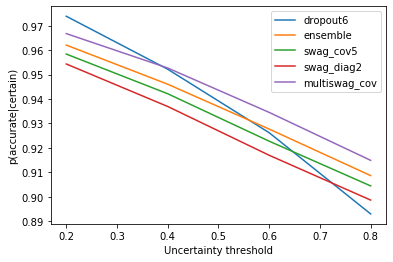

In [43]:
for model in res_dict:
    plt.plot(np.arange(0,1,0.2), res_dict[model]['cert'][0], label=model[:-4])

plt.xlabel('Uncertainty threshold')
plt.ylabel('p(accurate|certain)')
plt.legend()
plt.show()

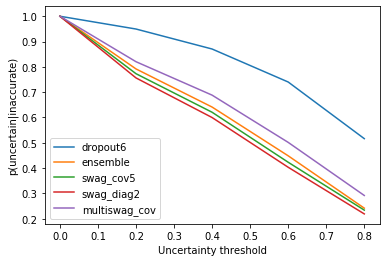

In [44]:
for model in res_dict:
    plt.plot(np.arange(0,1,0.2), res_dict[model]['cert'][1], label=model[:-4])

plt.xlabel('Uncertainty threshold')
plt.ylabel('p(uncertain|inaccurate)')
plt.legend()
plt.show()

In [9]:
npz_arr = np.load('../../results/swag_diag2.npz')

In [10]:
targets = npz_arr['targets']
targets.shape

(233, 360, 480)

In [11]:
pred = npz_arr['predictions']
pred.shape

(233, 11, 360, 480)

In [12]:
pred_uncertainty = npz_arr['predictive_entropy']
pred_uncertainty.shape

(233, 360, 480)

In [13]:
mut_uncertainty = npz_arr['mutual_information']
mut_uncertainty.shape

(233, 360, 480)

In [14]:
p_a_c, p_u_i, pa_v_pu, ac, au, ic, iu = eval_uncertaintry_metrics(pred, targets, pred_uncertainty, patch_size=6, cert_threshold=pred_uncertainty.mean())

0.9586136528812584 0.7913964702527173 0.7839851573676682


In [15]:
p_a_c.mean(), p_u_i.mean(), pa_v_pu.mean()

(0.9586136528812584, 0.7913964702527173, 0.7839851573676682)

In [16]:
import utils.imgs as img_utils

In [17]:
pred_labels = np.argmax(pred, axis=1)

In [18]:
entropy_max, entropy_min = pred_uncertainty.max(), pred_uncertainty.min()
pred_cert_viz = pred_uncertainty/entropy_max*255

info_max, info_min = mut_uncertainty.max(), mut_uncertainty.min()
info_cert_viz = mut_uncertainty/info_max*255

In [21]:
inputs[i].shape

(3, 360, 480)

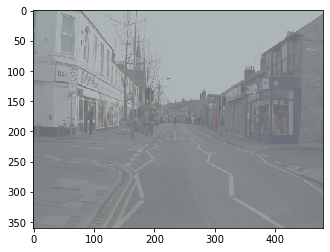

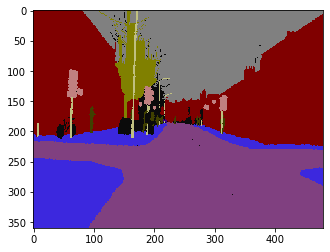

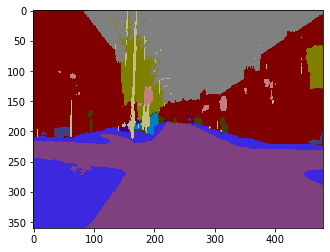

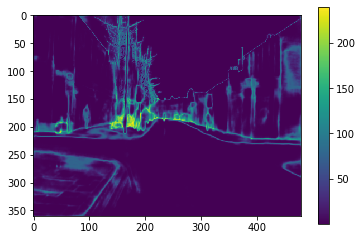

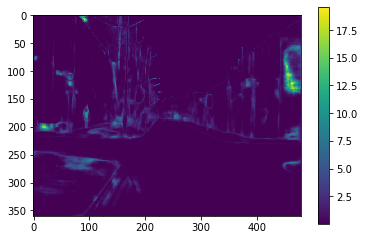

In [19]:
for i in range(1):
    img_utils.view_image(inputs[i])
    img_utils.view_annotated(targets[i])
    img_utils.view_annotated(pred_labels[i]) 
    plt.imshow(pred_cert_viz[i])
    plt.colorbar()
    plt.show()
    plt.imshow(info_cert_viz[i])
    plt.colorbar()
    plt.show()

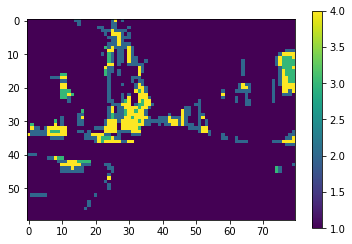

In [55]:
plt.imshow(ac[0]+au[0]*2+ic[0]*3+iu[0]*4)
plt.colorbar()